# Optimizador de distribución de dispositivos de feromonas en plantaciones

El objetivo es definir un algoritmo para optimizar la distribución de dispositivos en una plantación, de manera que se se minimice la cantidad de dispositivos sujeto a una restricción, y que éstos se distribuyan de manera uniforme en la plantación.

- El problema corresponde en definir _hileras_ de dispositivos en una hectárea con $P$ plantas, de manera que se minimice la cantidad de dispositivos instalados $k$, sujeto a una restricción de densidad mínima por hectárea $D$. Las densidades pueden ser $D \in \{200, 300, 500\}$. Se asume que $P \geq D$.
- Se requiere que los dispositivos estén distribuidos de manera uniforme en la hectárea. Sin embargo, no se requiere que la distribución sea estrictamente regular, y se prefieren patrones "simples" (ver más abajo), lo que motiva el uso de _hileras_ (ver a continuación).
- Una _hilera_ define un "patrón de instalación", que corresponde a un vector binario $H_i \in \mathbb{Z}^{P/n}$ que indica la posición de instalación de los dispositivos en la hilera $i$. La dimensionalidad de un vector $i$ corresponde al total de plantas ($P$) dividido por la cantidad de hileras ($n$). Por ejemplo, $H = [1\;0\;0\;1\;0\;0]$ indicaría que en una hilera de largo $P/n = 6$ habría que instalar un dispositivo cada tres plantas, comenzando por la primera.
- El problema entonces consiste en encontrar un conjunto $\mathcal{H} = \{H_1, H_2, \ldots, H_n\}$ de hileras que minimicen la cantidad de dispositivos $k$ en una plantación con $P$ plantas, sujeto a una restricción de densidad mínima $D$.

Complementario a las definiciones estrictas del problema, se definen las siguientes restricciones operacionales para la implementación práctica de una solución.

- Se requiere que los patrones definidos en $H_i$ sean "simples". La operacionalización de esta restricción se define a continuación.
- Es preferible minimizar la cardinalidad de $\mathcal{H}$, es decir, la cantidad $n$ de hileras definidas. Esto es, se prefiere un patrón de instalación con pocas hileras, que uno con muchas hileras.
- En términos operacionales, se requiere que la cantidad $k$ de dispositivos instalados no supere en 10\% la densidad mínima.

## Exploración del problema de optimización

### Ratio de instalación y definición de patrones "simples"

En principio, para un número $P$ de plantas y una densidad $D$ dadas, es trivial calcular un ratio óptimo de instalación $r^* = P/D$. Este ratio se interpreta como que debe instalarse un dispositivo cada $r^*$ plantas. Por ejemplo, si $P = 100$ y $D = 50$, entonces $r^* = 2$, lo que implica que debe instalarse un dispositivo cada dos plantas. Por ejemplo, una hilera con este ratio sería $H = [1\;0\;1\;0\;1\;0\;1\;0\;1\;0]$. Otra manera de interpretar el ratio es que $1/r$ es la densidad relativa de la hilera. Por ejemplo, aquí $D/P \equiv 1/r = 0.5$. La definición escogida para el ratio obedece a la interpretación más intuitiva que sugiere un patrón de instalación (i.e. "instalar un dispositivo cada $r$ plantas").


Sin embargo, este ratio puede no ser entero, y por lo tanto en la práctica no es posible instalar un dispositivo cada $r^*$ plantas. Por ejemplo, para $P = 110$ y $D = 50$, el ratio óptimo es $r^* = 2.2$ ($1/r^* = 0.\overline{45}$). Como no es posible instalar un dispositivo cada 2.2 plantas, entonces una solución trivial (pero no "simple") sería instalar un dispositivo cada dos plantas, y cada tanto intercalar un dispositivo cada tres plantas. Por ejemplo,

$$H = [1\;0\;1\;0\;1\;0\;1\;0\;1\;0\;0]$$
es un patrón que cumple con $1/r^* = 0.\overline{45}$, pero no es "simple" en el sentido que mezcla dos patrones de instalación diferentes en una misma hilera.

**De esta forma, operacionalizamos la restricción de mantener patrones "simples" como la restricción de que cada hilera posea un único patrón de instalación, y luego el proceso de optimización hacia el ratio óptimo $r^*$ se realiza en base a la elección de hileras que componen el conjunto $\mathcal{H} = \{H_1(r_1; P), \ldots, H_n(r_n; P)\}$.**

### Algoritmo de optimización

El problema de optimización consiste en encontrar un conjunto $\mathcal{H}^*$ de hileras que minimicen la cantidad de dispositivos $k$ en una plantación con $P$ plantas, sujeto a una restricción de densidad mínima $D$. Dado que el espacio de búsqueda es relativamente pequeño, se implementa un algoritmo de fuerza bruta que busca el conjunto $\mathcal{H}^*$ de hileras que minimice $k$.

#### Espacio de búsqueda

Comenzamos analizando el espacio de búsqueda, que depende de $r^*$. Como se mencionó anteriormente, este ratio puede no ser entero. Por lo tanto, el ratio óptimo $r^*$ debe ser aproximado por medio de una elección de $\mathcal{H} = \{H_1(r_1; P), \ldots, H_n(r_n; P)\}$ cuyo ratio resultante sea el más cercano a $r^*$.
Una manera simple de reducir el espacio de búsqueda es utilizar una combinación lineal de $\underbar{r} \equiv \lfloor r^* \rfloor, \bar{r} \equiv \lceil r^* \rceil$ para definir $\mathcal{H}$, es decir, $r_i \in \{\underbar{r}, \bar{r}\} \; \forall i$.
Por ejemplo, si $r^* = 2.2$, entonces utilizamos una combinación de hileras con $\underbar{r}=2$ y $\bar{r}=3$ para definir $\mathcal{H}$.
Si restringimos el número máximo de hileras a, por ejemplo, $\overline{n}=5$, entonces el espacio de búsqueda puede calcularse de la siguiente forma:

In [446]:
from itertools import combinations_with_replacement

def generate_combinations(elements, N):
    combinations = []
    for r in range(1, N+1):
        combinations.extend(combinations_with_replacement(elements, r))
    return combinations

generate_combinations([2, 3], 5)

[(2,),
 (3,),
 (2, 2),
 (2, 3),
 (3, 3),
 (2, 2, 2),
 (2, 2, 3),
 (2, 3, 3),
 (3, 3, 3),
 (2, 2, 2, 2),
 (2, 2, 2, 3),
 (2, 2, 3, 3),
 (2, 3, 3, 3),
 (3, 3, 3, 3),
 (2, 2, 2, 2, 2),
 (2, 2, 2, 2, 3),
 (2, 2, 2, 3, 3),
 (2, 2, 3, 3, 3),
 (2, 3, 3, 3, 3),
 (3, 3, 3, 3, 3)]

En la práctica, simulaciones con $r_i \in \{\underbar{r}, \bar{r}\}$ producen algunas soluciones que se exceden el máximo operacional de 10\% sobre la densidad mínima. Por lo tanto, se agrega un patrón adicional con $1/r = 0.\overline{6}$ al espacio de búsqueda.

# Implementación de un algoritmo de solución en Python

## Generación de patrones de instalación

Dejando de lado por el momento la búsqueda de una solución óptima al problema, se requiere primero definir una clase de objetos que permita generar patrones de instalación dada una configuración para $H$, es decir, un vector de ratios $R \in \mathbb{R}^n$.
Para esto, se define la clase `DevicePattern`, que recibe como parámetros la cantidad de plantas `P` (e.j. `P=444`), y un vector de ratios `R` (e.j. `R=[2, 3]`). Usando estos parámetros, la clase genera una matriz `H` de dimensiones `P/n x n`, que describe explícitamente la instalación de todos los dispositivos. Además, para este `H` se calcula el número real de dispositivos instalados, `k`.

In [448]:

import numpy as np

class DevicePattern:
    def __init__(self, P:int, R:np.array) -> None:
        self.P = P  # Total number of plants
        self.R = R  # r vector; len(R) is number of columns
        self.H = self.gen_H(P, R) # Pattern matrix
        self.k = np.sum(self.H)   # Computed density for this pattern

    def get_h(self, r, n:int):
        if np.modf(r)[0] == 0.5:
            return np.resize([1, 1, 0], n)
        return np.array([1 if i % r == 0 else 0 for i in range(n)])
    
    def gen_H(self, P:int, R:np.array):
        len_h = int(np.floor(P/len(R)))
        return np.array([self.get_h(r, len_h) for r in R])


El siguiente ejemplo ilustra el uso y resultado de la clase `DevicePattern`.
Definimos un patrón para `P=24` plantas y un vector de ratios `R=[2, 3]`.
Esto significa que definiremos dos hileras ($n=2$), de forma que $H = \{H_1, H_2\}$.
Cada hilera tiene un largo de $P/n = 12$ plantas.
En $H_1$ se instala un dispositivo cada dos plantas, y en $H_2$ se instala un dispositivo cada tres plantas.
También se calcula la densidad real de dispositivos, $k$, para evaluar posteriormente la optimalidad del patrón generado con estos parámetros.

In [441]:
pattern = DevicePattern(P=24, R=[2, 3])
pattern.k, pattern.H

(10,
 array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]]))

En este candidato a solución, se instalan 10 dispositivos, lo que corresponde a un ratio de instalación de $r = 2.4$. La matriz `H` representa el conjunto $\mathcal{H}$ de manera explícita, aunque los patrones de instalación están completamente definidos (y resumidos) en el vector `R`.

## Optimización de patrones de instalación

La optimización actual es rudimentaria, dado que el espacio de búsqueda es relativamente pequeño. Se define un algoritmo de fuerza bruta que prueba todas las combinaciones posibles de hileras, y se selecciona la que minimiza la cantidad de dispositivos $k$.

In [449]:
from itertools import combinations_with_replacement

class OptimalPattern:
    def __init__(self, D, P):
        self.D = D
        self.P = P
        self.ratio = P / D
        self.H_space = self.compute_H_space()

    def gen_ratios(self):
        def generate_combinations(elements, N):
            combinations = []
            for r in range(1, N+1):
                combinations.extend(combinations_with_replacement(elements, r))
            return combinations

        # Define ratio bounds    
        r_hi = int(np.floor(self.ratio))
        r_lo = int(np.ceil(self.ratio))

        # Check that bounds are different (i.e. ratio is not an integer)
        if r_hi != r_lo:
            r_mid = (r_hi + r_lo) / 2
            R = generate_combinations([r_hi, r_mid, r_lo], 5)
        else:
            R = [(self.ratio,)]
        return R
    
    def compute_H_space(self):
        R = self.gen_ratios()
        opt = []
        for r in R:
            H = DevicePattern(self.P, r)
            opt.append((H.k, r))
        return opt

    def find_optim_H(self):
        R = self.gen_ratios()
        opt = self.compute_H_space()
        opt = [sol for sol in opt if sol[0] >= self.D]   # Feasible solutions
        try:
            opt = min(opt, key=lambda item: item[0])
        except ValueError:
            print((opt, self.P))
            return
        return (opt[0], opt[1], DevicePattern(self.P, opt[1]).H)

A continuación se muestra un ejemplo de optimización para $P=444$ y $D=200$. La clase `OptimalPattern` recibe como parámetros la densidad mínima `D` y el número plantas `P`.
Luego, el método `find_optim_H()` implementa el algoritmo de optimización descrito arriba, y entrega una tupla con tres elementos:

1. `k`: número de dispositivos instalados,
2. `R`: vector de ratios que define el conjunto $\mathcal{H}$, y
3. `H`: matriz que describe explícitamente la instalación de los dispositivos.

En este ejemplo, la solución encontrada define un conjunto de $n=4$ hileras:
- $H_1$ con $r_1 = 2$ (instalar un dispositivo cada dos plantas),
- $H_2$ con $r_2 = 3$ (instalar un dispositivo cada tres plantas),
- $H_3$ y $H_4$ con $r = 3$ (instalar un dispositivo cada tres plantas),

In [450]:
# Test single pattern

opt = OptimalPattern(200, 444)
opt.find_optim_H()


(204,
 (2, 2.5, 3, 3),
 array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1],
        [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
         0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
         1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
         0],
        [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 

### Evaluación del algoritmo de optimización

Podemos evaluar sistemáticamente el algoritmo de optimización fijando el valor de $D$ y variando $P$. Nos interesa verificar que las soluciones $k$ que se generan para distintos valores de $P$ satisfacen $D \leq k \leq 1.1D$. Es decir, verificar que las soluciones son
- factibles, es decir, ninguna es menor que la densidad ($k \geq D$); y
- óptimas, es decir, ninguna solución supera la densidad en más de 10% ($k \leq 1.1D$)

In [510]:
from itertools import groupby
import matplotlib.pyplot as plt

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

def gen_solutions_eval(D, P_ub=1000):
    P = range(D, P_ub, 1)
    sols = [foo.find_optim_H() for foo in [OptimalPattern(D, n) for n in range(D, P_ub, 1)]]
    K = np.array([y[0] for y in sols])
    N = np.array([int(len(y[1])) if not all_equal(y[1]) else 1 for y in sols])
    return (P, K, N)

def gen_eval_plot(D, P, K, N):

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('plantas (P)')
    ax1.set_ylabel('densidad real (k)', color=color)
    ax1.plot(P, K, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('número de hileras (n)', color=color)  # we already handled the x-label with ax1
    ax2.scatter(P, N, color=color, s=1)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.yticks(np.arange(1, 7, 1))

    # horizontal line indicating D
    ax1.axhline(y=D, color='tab:gray', linestyle='-', alpha=0.5)
    ax1.axhline(y=D*1.1, color='tab:gray', linestyle='-', alpha=0.5)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Densidad real y número de hileras para D = {}'.format(D))
    return plt

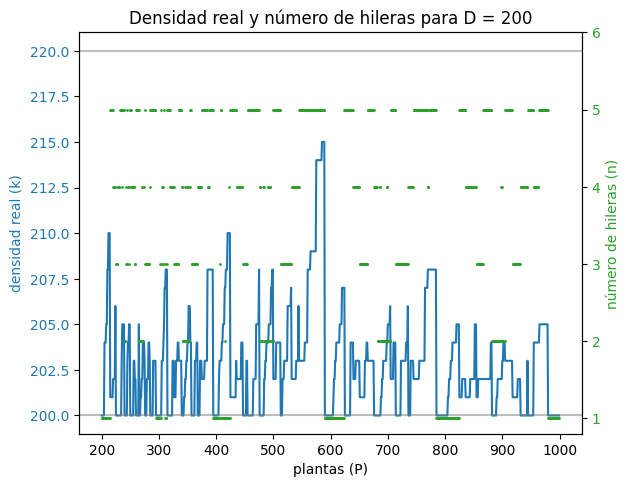

In [511]:
D = 200
P, K, N = gen_solutions_eval(D)
gen_eval_plot(D, P, K, N).show()

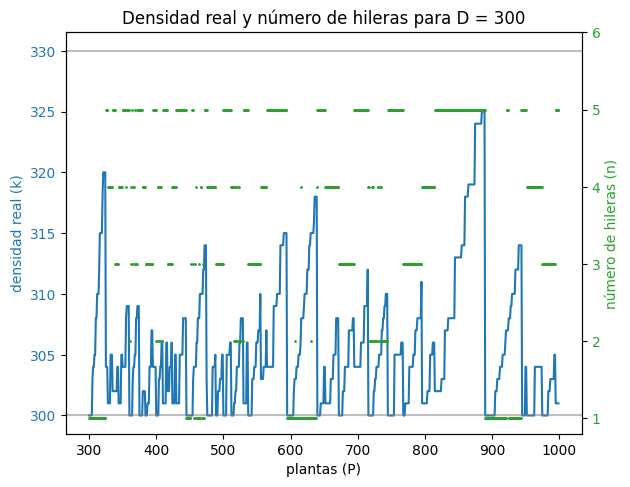

In [512]:

D = 300
P, K, N = gen_solutions_eval(D)
gen_eval_plot(D, P, K, N).show()

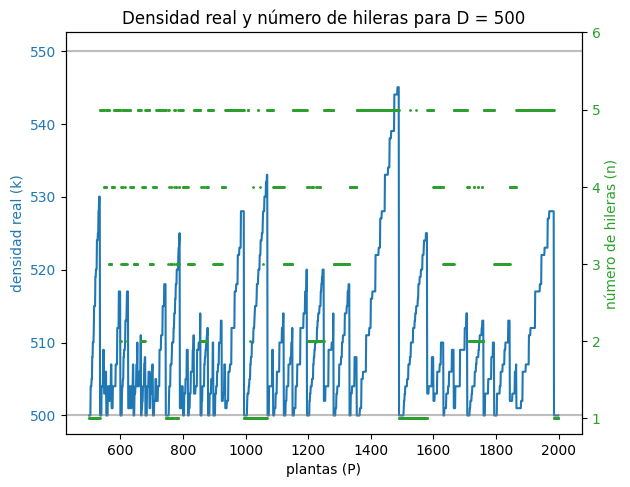

In [513]:
D = 500
P, K, N = gen_solutions_eval(D, P_ub=2000)
gen_eval_plot(D, P, K, N).show()

In [524]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective_function(x, P, alpha):
    n = int(x[0])
    r = x[1:]
    k = (P / n) * np.sum(r) + alpha * n
    return k

# Define the constraint function
def constraint_function(x, P, D):
    n = int(x[0])
    r = x[1:]
    return (P / n) * np.sum(r) - D

# Set the constants and parameters
P = 60  # Choose an appropriate value for P
alpha = 100  # Choose an appropriate value for alpha
D = 30  # Choose an appropriate value for D

# Define the bounds for the variables
bounds = [(1, None)] + [(0, None)] * 10  # n >= 1, r_i >= 0

# Define the constraint for r_i values
def r_constraint(x):
    r = x[1:]
    return np.array([r[i-1] - 1/i for i in range(1, len(r)+1)])

# Define the custom constraint
def custom_constraint(x, P, D):
    constraints = []
    constraints.append(constraint_function(x, P, D))
    constraints.extend(r_constraint(x))
    return constraints

# Set the initial guess for the variables
x0 = np.ones(11)  # [n, r1, r2, ..., r10]

# Define the constraints
constraints = {'type': 'ineq', 'fun': custom_constraint, 'args': (P, D)}

# Solve the optimization problem
result = minimize(objective_function, x0, args=(P, alpha), bounds=bounds, constraints=constraints)

# Extract the optimal solution
optimal_n = int(result.x[0])
optimal_r = result.x[1:]

print("Optimal n:", optimal_n)
print("Optimal r:", optimal_r)


Optimal n: 1
Optimal r: [1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1       ]


In [522]:
def gen_n_devices

TypeError: 'int' object is not subscriptable

In [584]:
def parse_args(X):
    R = np.array(X)
    n = len(R)
    return n, R

def fun_d(R, p, n):
    return (p / n) * np.sum(R)

def objective_function(X, p):
    n, R = parse_args(X)
    k = fun_d(R, p, n)
    return k

def constraint_function(X, p, d_min):
    n, R = parse_args(X)
    return fun_d(R, p, n) - d_min

# Set the constants and parameters
P = 60  # Choose an appropriate value for P
alpha = 0  # Choose an appropriate value for alpha
D = 18  # Choose an appropriate value for D
len_R = 4

# Define the bounds for the variables
bounds = [(0, 1)] * len_R  # n >= 1, r_i >= 0

# Define the constraint for r_i values
def r_constraint(x):
    # r = x[1:]
    # return np.array([r[i-1] - 1/i for i in range(1, len(r)+1)])
    return np.array([1, 4/5, 3/4, 2/3] + [1/i for i in range(2, 6)])

# Define the custom constraint
def custom_constraint(X, p, d_min):
    constraints = []
    constraints.append(constraint_function(X, p, d_min))
    constraints.extend(r_constraint(X))
    return constraints

# Set the initial guess for the variables
x0 = np.ones(len_R)  # [n, r1, r2, ..., r10]

# Define the constraints
constraints = {'type': 'ineq', 'fun': custom_constraint, 'args': (P, D)}

# Solve the optimization problem
result = minimize(objective_function, x0, args=(P, ), bounds=bounds, constraints=constraints)

# Extract the optimal solution
optimal_n = int(result.x[0])
optimal_r = result.x[1:]

print("Optimal n:", optimal_n)
print("Optimal r:", optimal_r)

Optimal n: 0
Optimal r: [0.3 0.3 0.3]


In [585]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 17.999999999918828
       x: [ 3.000e-01  3.000e-01  3.000e-01  3.000e-01]
     nit: 2
     jac: [ 1.500e+01  1.500e+01  1.500e+01  1.500e+01]
    nfev: 10
    njev: 2

In [549]:
r = [1, 0.5]
np.array([r[i-1] - 1/i for i in range(1, len(r)+1)])

array([0., 0.])

In [555]:
np.array([1, 4/5, 3/4, 2/3] + [1/i for i in range(2, 6)])

array([1.        , 0.8       , 0.75      , 0.66666667, 0.5       ,
       0.33333333, 0.25      , 0.2       ])

In [589]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function
def objective_function(r, P):
    n = len(r)
    return np.sum(np.ceil(r * P / n))

# Define the constraint function
def constraint_function(r, P, R, d_min):
    n = len(r)
    return np.sum(np.ceil(r * P / n)) - d_min

# Set the constants and parameters
P = 60  # Choose an appropriate value for P
d_min = 30  # Choose an appropriate value for the lower bound d_min

# Set the values for R (r_i values)
R = np.array([1/i for i in range(1, 11)])  # Values for r_i: [1/1, 1/2, ..., 1/10]

# Set the initial guess for r
r_initial = np.ones(len(R))

# Define the bounds for r
bounds = [(1/i, 1/i) for i in range(1, len(R) + 1)]

# Define the constraint
constraint = {'type': 'ineq', 'fun': constraint_function, 'args': (P, R, d_min)}

# Solve the optimization problem
result = minimize(objective_function, r_initial, args=(P,), bounds=bounds, constraints=constraint)

# Extract the optimal solution
optimal_r = result.x

print("Optimal r:", optimal_r)


Optimal r: [1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1       ]


In [590]:
R

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ])

In [591]:
bounds

[(1.0, 1.0),
 (0.5, 0.5),
 (0.3333333333333333, 0.3333333333333333),
 (0.25, 0.25),
 (0.2, 0.2),
 (0.16666666666666666, 0.16666666666666666),
 (0.14285714285714285, 0.14285714285714285),
 (0.125, 0.125),
 (0.1111111111111111, 0.1111111111111111),
 (0.1, 0.1)]

In [592]:
I need you to help me write a simpler minimization problem. Let's start with the objective function. I want to minimize the sum of the ceiling function of r_i * P/n. Can you write that in rendered Latex?

Let's call the sum $d$. I need to add a constraint where $d > \underbar{d}$

Excellent. The final ingredient to add is that each $r_i$ can only take specific values, that are of the form $1/i$ with $i$ ranging from 1 to 10.

Object `Latex` not found.


In [593]:
from ortools.linear_solver import pywraplp

# Set the parameters
n = 10
P = 5
d_bar = 10

# Initialize the solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Decision variables
r = []
for i in range(1, n + 1):
    r.append(solver.IntVar(1. / i, 1., 'r[%i]' % i))

# Objective function
objective = solver.Objective()
for i in range(n):
    objective.SetCoefficient(r[i], P / n)
objective.SetMinimization()

# Constraint
constraint = solver.Constraint(d_bar, solver.infinity())
for i in range(n):
    constraint.SetCoefficient(r[i], 1)

# Solve the problem
status = solver.Solve()

# Print the solution
if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', objective.Value())
    for i in range(n):
        print('r[%i] = %f' % (i, r[i].solution_value()))
else:
    print('The problem does not have an optimal solution.')


Objective value = 5.0
r[0] = 1.000000
r[1] = 1.000000
r[2] = 1.000000
r[3] = 1.000000
r[4] = 1.000000
r[5] = 1.000000
r[6] = 1.000000
r[7] = 1.000000
r[8] = 1.000000
r[9] = 1.000000


In [594]:
r

[r[1], r[2], r[3], r[4], r[5], r[6], r[7], r[8], r[9], r[10]]

In [597]:
\r[0][0]

TypeError: 'Variable' object is not subscriptable